# Benchmark: PXD024043 - Proteins

This notebook contains code to benchmark the model on the [PXD024043 dataset](https://www.ebi.ac.uk/pride/archive/projects/PXD024043) - cell cycle proteomes. 
Four cell populations enriched in different cell cycle stages were produced from HeLa cells by drug treatment.
Here, we'll use the protein dataset. Download the zip-file, "DIANN1.8_SingleCells_CellCycle.zip" and locate the file, "20210919_DIANN_SingleCellOutput.pg_matrix.tsv".

Let's start with the imports.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import torch
from scipy.stats import spearmanr, pearsonr

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from protvi.models import PROTVI
import protvi.plots as pl
import protvi.utils as utils
import protvi.benchmark_models as bm

import scvi

np.random.seed(42)
scvi.settings.seed = 42

/home/rasmus/sollertis/job/ra/protvi/MS_mv_modelling/.conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


Let's define the path to the data.

In [2]:
adata = sc.read_h5ad("../../../data/processed/brunner2022.h5ad")

In [3]:
print(f"nan intensities: {np.isnan(adata.layers['raw']).sum() / (adata.shape[0] * adata.shape[1]) * 100:.2f}%")

nan intensities: 48.24%


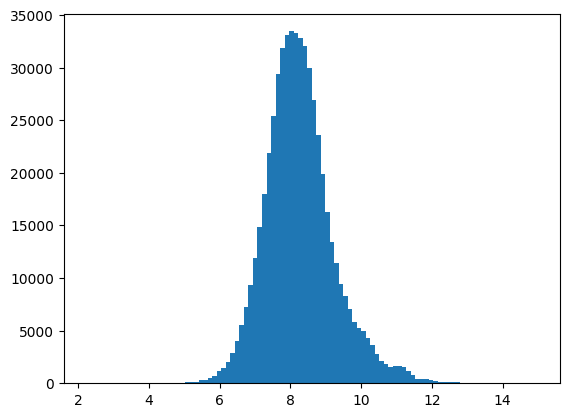

In [4]:
plt.hist(adata.layers["raw"].flatten(), bins=100)
plt.show()

## Data Exploration

{'heatmap_ax': <Axes: >, 'groupby_ax': <Axes: ylabel='cell cycle stage'>}

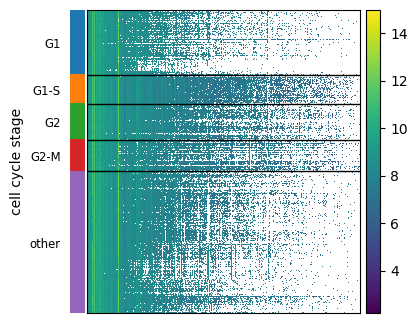

In [5]:
adata = utils.sort_anndata_by_missingness(adata, layer="raw")

adata.obs["cell cycle stage"] = adata.obs["cell_cycle_stage"]

sc.pl.heatmap(adata, var_names=adata.var_names, groupby="cell cycle stage", show_gene_labels=False, figsize=(4, 4), show=False)

In [6]:
protein_missingness = utils.get_missingness_per_protein(adata, layer="raw")
print(f"Proteins with no missing values: {np.sum(protein_missingness == 0) / len(protein_missingness) * 100:.2f}%")

Proteins with no missing values: 5.76%


In [7]:
adata.shape

(434, 2501)

In [8]:
adata.obs

,date,unknown1,n_cells,species,unknown2,unknown3,unknown4,position,replicate,file_index,condition,coarse_condition,cell_cycle_stage,cell cycle stage
20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_01_S3-G2_1_3873.d,20201009,AnBr,1Cell,HeLa,NB,01,S3,G2,1,3873,G1-M,G,G2-M,G2-M
20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_02_S3-G3_1_3874.d,20201009,AnBr,1Cell,HeLa,NB,02,S3,G3,1,3874,G1-M,G,G2-M,G2-M
20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_03_S3-G4_1_3875.d,20201009,AnBr,1Cell,HeLa,NB,03,S3,G4,1,3875,G1-M,G,G2-M,G2-M
20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_04_S3-G5_1_3876.d,20201009,AnBr,1Cell,HeLa,NB,04,S3,G5,1,3876,G1-M,G,G2-M,G2-M
20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_05_S3-G6_1_3877.d,20201009,AnBr,1Cell,HeLa,NB,05,S3,G6,1,3877,G1-M,G,G2-M,G2-M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20201126_TIMS04_Evo07_SA_ADB_1cell_HeLa_UB_163_S2-H7_1_5174.d,20201126,SA-ADB,1cell,HeLa,UB,163,S2,H7,1,5174,UB_Passage02_Plate02,UB,other,other
20201126_TIMS04_Evo07_SA_ADB_1cell_HeLa_UB_164_S2-H8_1_5175.d,20201126,SA-ADB,1cell,HeLa,UB,164,S2,H8,1,5175,UB_Passage02_Plate02,UB,other,other
20201126_TIMS04_Evo07_SA_ADB_1cell_HeLa_UB_165_S2-H9_1_5176.d,20201126,SA-ADB,1cell,HeLa,UB,165,S2,H9,1,5176,UB_Passage02_Plate02,UB,other,other
20201126_TIMS04_Evo07_SA_ADB_1cell_HeLa_UB_166_S2-H10_1_5177.d,20201126,SA-ADB,1cell,HeLa,UB,166,S2,H10,1,5177,UB_Passage02_Plate02,UB,other,other


Let's see if we can decide which annotation is the batch effect.

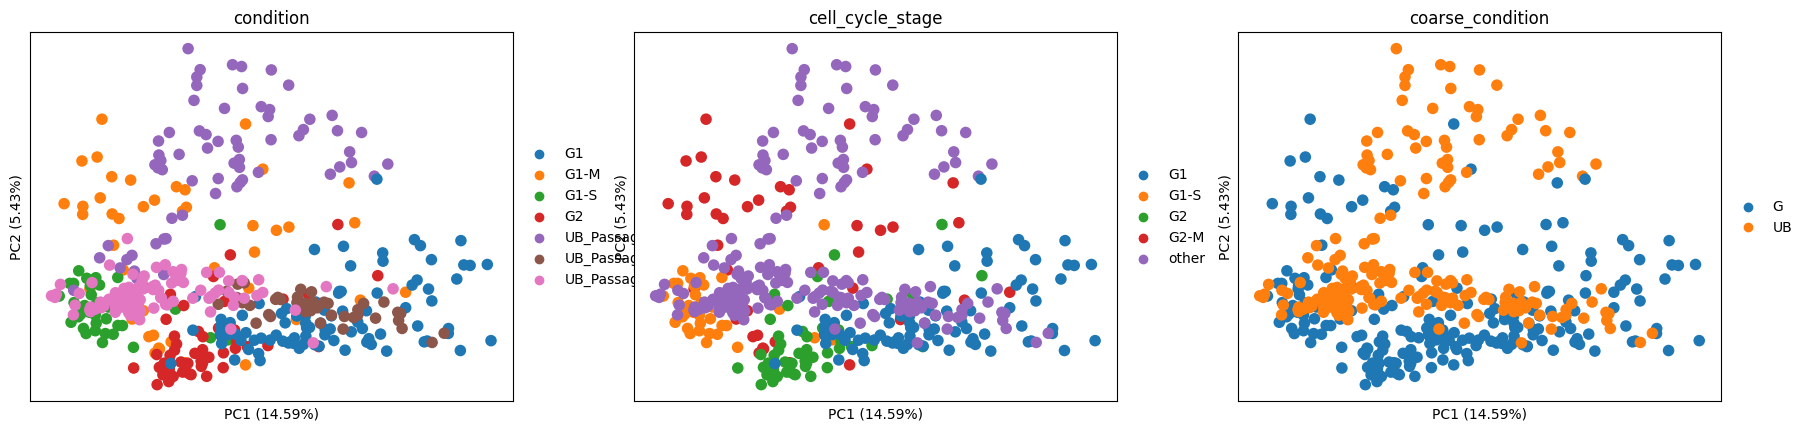

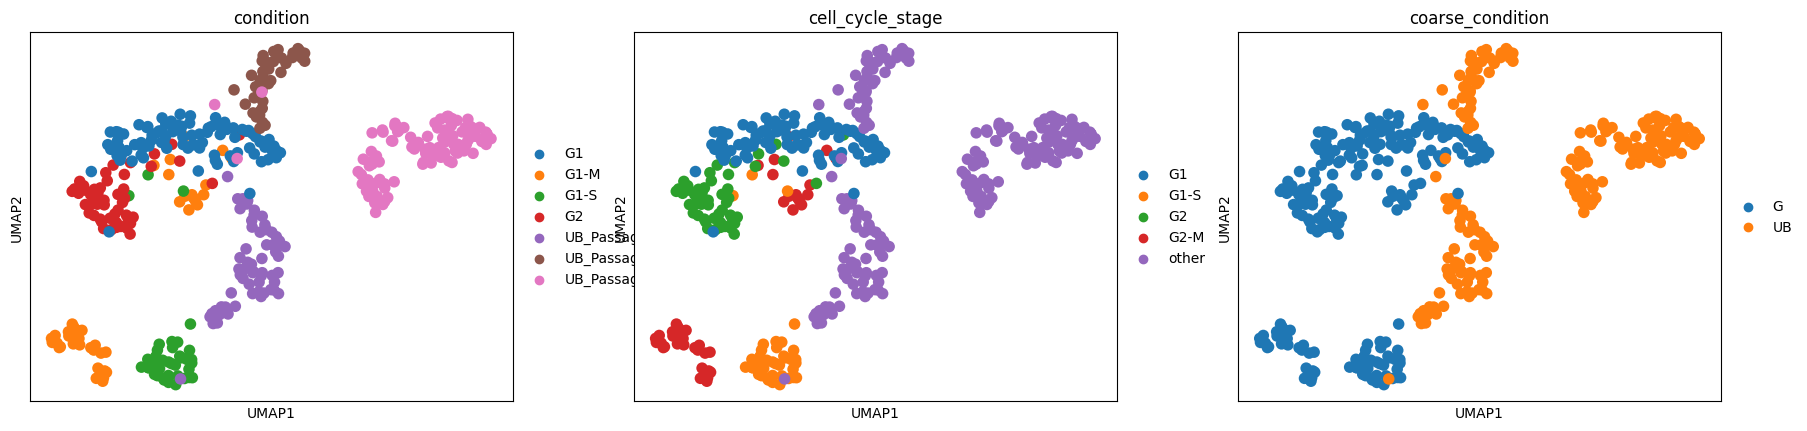

In [9]:
adata.X = bm.impute_downshifted_normal_sample(adata, layer="raw")

sc.tl.pca(adata, n_comps=16)

sc.pl.pca(
    adata,
    annotate_var_explained=True,
    color=["condition", "cell_cycle_stage", "coarse_condition"], 
    components=["1,2"],
)

sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color=["condition", "cell_cycle_stage", "coarse_condition"], 
)

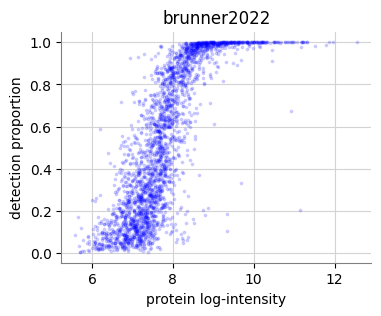

In [10]:
pl.scatter_protein_detection_proportion_and_intensity(adata.layers["raw"], title="brunner2022") #, title="raw")